#### Architecture - Semantic Search using Elastic Search


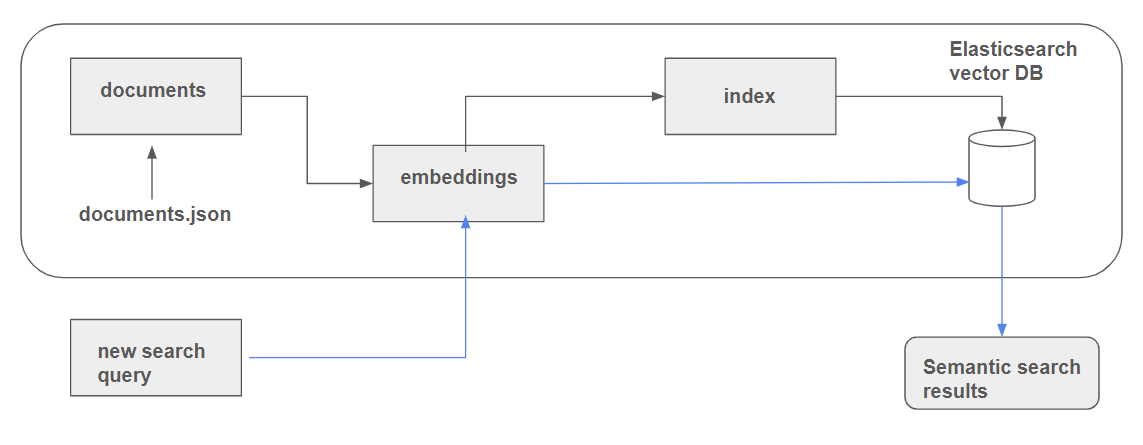

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

In [1]:
#pip install elasticsearch

In [2]:
#pip install sentence_transformers==2.7.0 pandas

In [3]:
#import requests

In [23]:
#import numpy as np

In [18]:
#from tqdm.auto import tqdm

#### Q1. Getting the embeddings model

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
user_question = "I just discovered the course. Can I still join it?"

In [8]:
v = model.encode(user_question)

In [9]:
len(v)

768

#### First Value, at index 0

In [10]:
v[0]

0.078222655

#### Second Value, at index 1

In [11]:
v[1]

-0.04013114

#### Prepare the documents

In [12]:
import json
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [13]:
document_filtered =[]
for doc in documents:
    if doc['course'] == "machine-learning-zoomcamp":
        document_filtered.append(doc)

In [14]:
len(documents)

948

In [15]:
len(document_filtered)

375

In [16]:
documents = document_filtered

#### Q2. Creating the embeddings

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [21]:
embeddings = []
for doc in tqdm(documents):
    qa_text = f"{doc['question']} {doc['text']}"
    # Transforming the qa_text into an embedding using the model
    doc["text_vector"] = model.encode(qa_text)
    embeddings.append(doc["text_vector"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [01:02<00:00,  6.03it/s]


In [24]:
X = np.array(embeddings)

In [25]:
X.shape

(375, 768)

#### Q3. Search

In [26]:
scores = X.dot(v)

In [27]:
scores.max()

0.6506573

#### Vector Search

In [28]:
class VectorSearchEngine():
    def __init__(self, documents, embeddings):
        self.documents = documents
        self.embeddings = embeddings

    def search(self, v_query, num_results=10):
        scores = self.embeddings.dot(v_query)
        idx = np.argsort(-scores)[:num_results]
        return [self.documents[i] for i in idx]

search_engine = VectorSearchEngine(documents=documents, embeddings=X)
search_engine.search(v, num_results=5)

[{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'section': 'General course-related questions',
  'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'id': 'ee58a693',
  'text_vector': array([ 8.06286409e-02, -6.66388795e-02,  2.52730623e-02, -1.30044082e-02,
          7.58728236e-02, -5.94627075e-02, -2.18838379e-02,  2.90004001e-03,
          7.92835199e-04, -5.22241509e-03, -3.36517990e-02, -2.79135145e-02,
          5.81165552e-02,  3.97483334e-02,  5.44185564e-02, -3.82517129e-02,
          6.30573705e-02, -3.89698781e-02,  4.33594891e-04, -3.55845094e-02,
          1.75642478e-03,  2.5700

#### Q4. Hit-rate for our search engine

In [29]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [40]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        v_q_g = model.encode(q["question"])
        results = search_function(v_q_g, num_results=5)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [41]:
evaluate(ground_truth,search_engine.search)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:25<00:00, 21.36it/s]


{'hit_rate': 0.9398907103825137, 'mrr': 0.8516484517304189}

#### Q5. Indexing with Elasticsearch

In [84]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": True,
                "similarity": "cosine"
            },
            "text_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": True,
                "similarity": "cosine"
            },
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 768,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [85]:
for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    qt = question + ' ' + text

    doc['question_vector'] = model.encode(question)
    doc['text_vector'] = model.encode(text)
    doc['question_text_vector'] = model.encode(qt)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [02:07<00:00,  2.94it/s]


In [86]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [00:07<00:00, 47.73it/s]


In [92]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = es_results
    
    #for hit in es_results['hits']['hits']:
        #result_docs.append(hit['_source'])

    return result_docs

In [93]:
v_q_q1 = model.encode(user_question)

In [95]:
es_results = elastic_search_knn('question_vector', v_q_q1, "machine-learning-zoomcamp")

In [103]:
es_results['hits']['hits'][0]

{'_index': 'course-questions',
 '_id': '93G8wpAB8DNQ2vVQ4MPA',
 '_score': 0.96726,
 '_source': {'question': 'The course has already started. Can I still join it?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
  'id': 'ee58a693'}}

#### Q6. Hit-rate for Elasticsearch

In [104]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

In [105]:
def question_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_vector', v_q, course)

In [106]:
def evaluate_knn(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [107]:
evaluate_knn(ground_truth, question_vector_knn)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [01:22<00:00, 22.11it/s]


{'hit_rate': 0.8076502732240437, 'mrr': 0.6985519125683067}